# IEOR 242 - ICO success prediction project

## Dead coin prediction

In [2]:
library(caret)
library(MASS)
library(caTools)
library(randomForest)
library(ggplot2)
library(GGally)
library(car)
library(rpart)
library(rattle)
library(boot)
library(dplyr)
library(ROCR)

mean_squared_error <- function(responses, predictions) {
  MSE <- mean(((responses - predictions))^2)
  return(MSE)
}

mean_absolute_error <- function(responses, predictions) {
  MAE <- mean(abs(responses - predictions))
  return(MAE)
}

OS_R_squared <- function(responses, predictions, train_responses) {
  baseline <- mean(train_responses)
  SSE <- sum((responses - predictions)^2)
  SST <- sum((responses - baseline)^2)
  r2 <- 1 - SSE/SST
  return(r2)
}

all_metrics <- function(responses, predictions, train_responses) {
  filter_vec = !is.na(responses) & !is.na(predictions)
  responses <- responses[filter_vec]
  predictions <- predictions[filter_vec]
  train_responses <- train_responses[filter_vec]
  mse <- mean_squared_error(responses, predictions)
  mae <- mean_absolute_error(responses, predictions)
  OSR2 <- OS_R_squared(responses, predictions, train_responses)
  return(c(mse, mae, OSR2))
}

tableAccuracy <- function(label, pred) {
  t = table(label, pred)
  a = sum(diag(t))/length(label)
  return(a)
}

tableTPR <- function(label, pred) {
  t = table(label, pred)
  return(t[2,2]/(t[2,1] + t[2,2]))
}

tableFPR <- function(label, pred) {
  t = table(label, pred)
  return(t[1,2]/(t[1,1] + t[1,2]))
}

Loading required package: lattice
Loading required package: ggplot2
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: carData
Rattle: A free graphical interface for data science with R.
Version 5.3.0 Copyright (c) 2006-2018 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

Attaching package: ‘rattle’

The following object is masked from ‘package:randomForest’:

    importance


Attaching package: ‘boot’

The following object is masked from ‘package:car’:

    logit

The following object is masked from ‘package:lattice’:

    melanoma


Attaching package: ‘dplyr’

The following object is masked from ‘package:car’:

    recode

The following object is masked from ‘package:GGally’:

    nasa

The following object is masked from ‘package:randomForest’:

    combine

The following object is masked from ‘package:MASS’:

We load the preprocessed data:

In [3]:
df <- read.csv("../python/coincheckup/dataset.csv", stringsAsFactors=FALSE, na="")
df$label_disappeared = as.factor(df$label_disappeared)
# name and Symbol are the only strings

a) Logistic regression

We begin with a logistic regression on the features which are numeric and nhave a very low rate of NAs:

In [4]:
set.seed(42)
split = sample.split(df$label_disappeared, SplitRatio = 0.7)
train_data <- filter(df, split== TRUE)
test_data <- filter(df, split== FALSE)

table(train_data$label_disappeared)
table(test_data$label_disappeared)

#LOGISTIC
logistic <- glm(label_disappeared ~ Price + X1h + X24h + X7d + X14d + X30d + X45d + X90d + X200d + 
                  Mkt..Cap + X24h.Vol + Circ..Supply + Total.Supply + Team + Product + Coin + Social + Communication + Business + Avg..volume + Age..mo., data = train_data, family="binomial")
summary(logistic)

pred = predict(logistic, newdata = test_data, type="response")

table(test_data$label_disappeared, pred>0.2)

tableAccuracy(test_data$label_disappeared, pred>0.2)
tableTPR(test_data$label_disappeared, pred>0.2)
tableFPR(test_data$label_disappeared, pred>0.2)

vif(logistic)


FALSE  TRUE 
 1025   208 


FALSE  TRUE 
  439    89 

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = label_disappeared ~ Price + X1h + X24h + X7d + 
    X14d + X30d + X45d + X90d + X200d + Mkt..Cap + X24h.Vol + 
    Circ..Supply + Total.Supply + Team + Product + Coin + Social + 
    Communication + Business + Avg..volume + Age..mo., family = "binomial", 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4129  -0.6457  -0.4438  -0.2806   2.6774  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)   
(Intercept)    4.904e-02  4.592e-01   0.107  0.91494   
Price         -5.873e-03  1.089e-02  -0.539  0.58957   
X1h            7.936e-05  5.658e-03   0.014  0.98881   
X24h           4.684e-04  2.211e-03   0.212  0.83221   
X7d            2.764e-03  1.811e-03   1.526  0.12690   
X14d          -5.093e-04  1.361e-03  -0.374  0.70821   
X30d           5.891e-04  2.114e-03   0.279  0.78049   
X45d          -6.051e-03  2.321e-03  -2.608  0.00912 **
X90d           2.879e-03  1.871e-03   1.539  0.12384   
X200d      

       
        FALSE TRUE
  FALSE   307  117
  TRUE     31   55

[1] 0.6856061

[1] 0.6395349

[1] 0.2759434

Price           X1h          X24h           X7d          X14d 
     1.025848      1.157698      2.960334      2.951850      3.240903 
         X30d          X45d          X90d         X200d      Mkt..Cap 
     4.918177      4.597833      2.611983      1.913316      1.036472 
     X24h.Vol  Circ..Supply  Total.Supply          Team       Product 
     1.034911      1.050182      1.038608      7.106485      1.816586 
         Coin        Social Communication      Business   Avg..volume 
     2.198319      3.196033      1.468752      1.592286      1.016460 
     Age..mo. 
     1.369327

Then we reduce the range of features to the relevant ones and make a final logistic model, that we compare to the baseline:

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = label_disappeared ~ X45d + Social + 0, family = "binomial", 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1773  -0.6347  -0.4854  -0.3496   2.7011  

Coefficients:
        Estimate Std. Error z value Pr(>|z|)    
X45d   -0.004062   0.001108  -3.667 0.000245 ***
Social -0.032039   0.001607 -19.935  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1696.8  on 1224  degrees of freedom
Residual deviance: 1011.9  on 1222  degrees of freedom
  (9 observations deleted due to missingness)
AIC: 1015.9

Number of Fisher Scoring iterations: 8


       
        FALSE TRUE
  FALSE   320  117
  TRUE     37   52

[1] 0.7045455

[1] 0.5842697

[1] 0.2677346

FALSE 
0.8314394

[1] 0.7089193

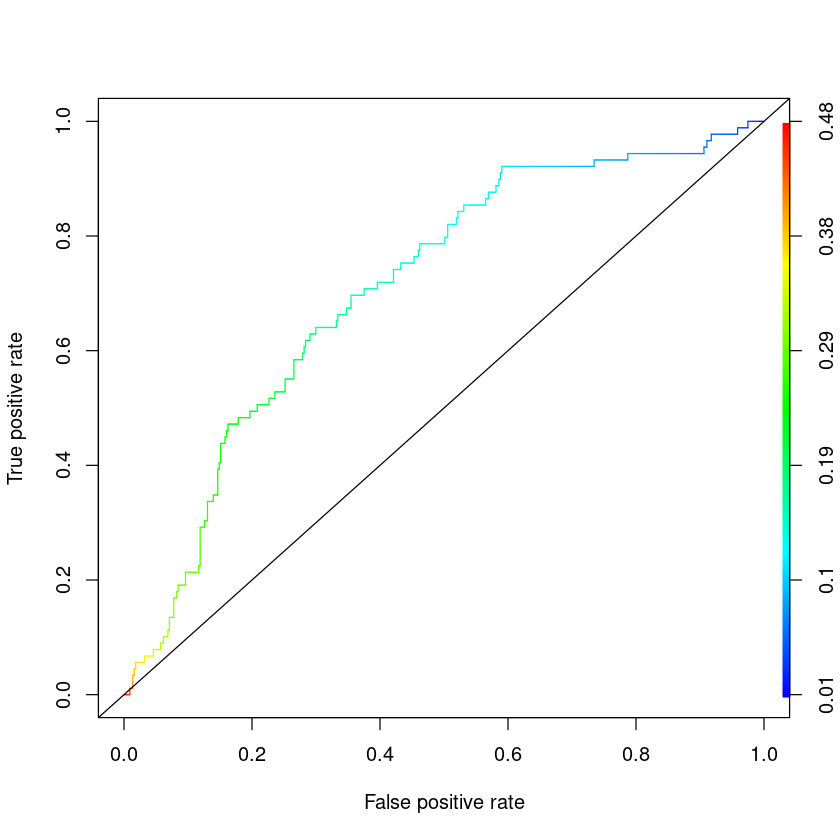

In [5]:
logistic <- glm(label_disappeared ~ X45d + Social + 0, data = train_data, family="binomial")
summary(logistic)

pred = predict(logistic, newdata = test_data, type="response")

table(test_data$label_disappeared, pred>0.2)

tableAccuracy(test_data$label_disappeared, pred>0.2)
tableTPR(test_data$label_disappeared, pred>0.2)
tableFPR(test_data$label_disappeared, pred>0.2)

# Baseline accuracy:
t_ <- table(test_data$label_disappeared)
t_[1]/sum(t_)

rocr.pred <- prediction(pred, test_data$label_disappeared)
perf <- performance(rocr.pred, "tpr", "fpr")
plot(perf, colorize = TRUE)
abline(0, 1)
as.numeric(performance(rocr.pred, "auc")@y.values)

b) Random Forest

Let's begin checking the number of NAs in each column to select the features.

In [10]:
sapply(df, function(x){ sum(is.na(x)) })

Name                       MC.. 
                         0                          0 
                    Symbol                      Price 
                         0                          0 
                       BTC                        X1h 
                         0                          0 
                      X24h                        X7d 
                         0                          0 
                      X14d                       X30d 
                         0                          4 
                      X45d                       X90d 
                        11                         22 
                     X200d                   Mkt..Cap 
                        48                          0 
                  MCAP.BTC                   X24h.Vol 
                         0                          0 
              X24h.Vol.BTC               Circ..Supply 
                         0                          0 
              Total.Supply                Max..Supply 
                         9                       1394 
                      Team                   Advisors 
                         0                        566 
                Brand.Buzz                    Product 
                       566                          0 
                      Coin                     Social 
                         0                          0 
             Communication                   Business 
                         0                          0 
                    GitHub                   GitHub.1 
                       697                        697 
               Avg..volume                   Age..mo. 
                         0                          1 
            Winning.months                label_Price 
                         1                        297 
            label_Mkt..Cap    label_growth_rate_Price 
                       297                        297 
label_growth_rate_Mkt..Cap          label_disappeared 
                       297                          0

Now let's try a random forest with cross-validation. The dataset is not balanced so we try a cross-validation measured with Accuracy and then F1-score as Accuracy is less relevant in this case.

mtry,Accuracy,Kappa,AccuracySD,KappaSD
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8480651,0.1820981,0.01230487,0.07219353
2,0.8497045,0.2675792,0.01730529,0.08837830
3,0.8545991,0.3131013,0.01457905,0.07484737
4,0.8505074,0.2927120,0.01216925,0.05062367
5,0.8505175,0.3181606,0.01943042,0.07520890
6,0.8472421,0.2995333,0.01863631,0.06998712
7,0.8407181,0.2733978,0.02110235,0.08098173


Random Forest 

1233 samples
   7 predictor
   2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 980, 978, 980, 979, 979 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  1     0.8480651  0.1820981
  2     0.8497045  0.2675792
  3     0.8545991  0.3131013
  4     0.8505074  0.2927120
  5     0.8505175  0.3181606
  6     0.8472421  0.2995333
  7     0.8407181  0.2733978

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 3.

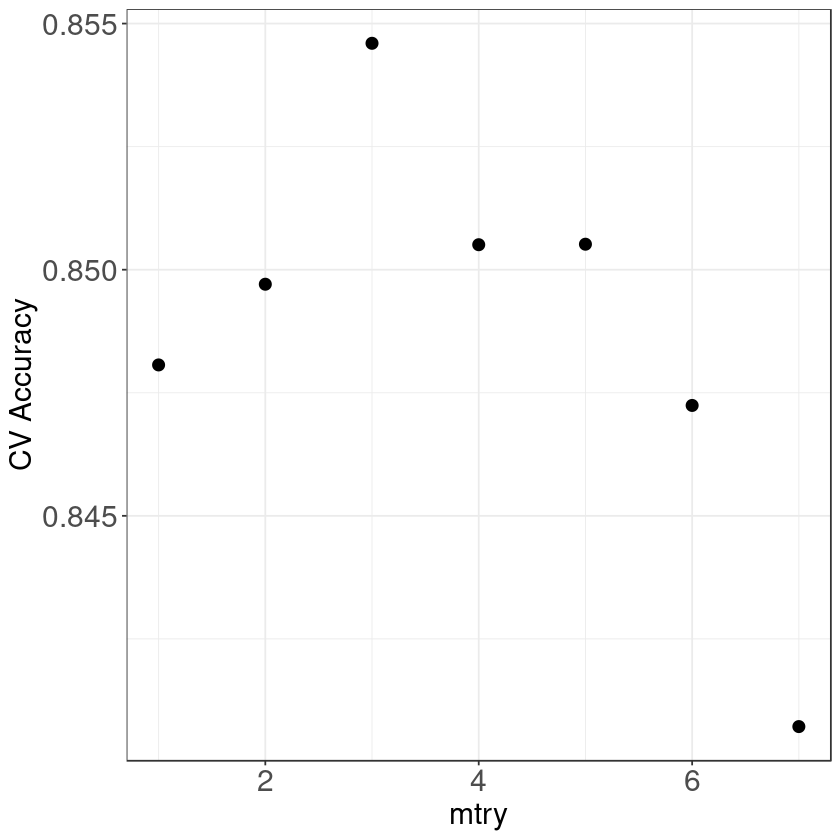

In [11]:
set.seed(42)
test_data_filled_with_0 <- test_data
test_data_filled_with_0[is.na(test_data_filled_with_0)] <- 0
train_data.mm = as.data.frame(model.matrix(label_disappeared ~ X24h + X14d + X45d + Social + Mkt..Cap + Age..mo. + Business, data = train_data)) 
test_data.mm = as.data.frame(model.matrix(label_disappeared ~ X24h + X14d + X45d + Social + Mkt..Cap + Age..mo. + Business, data = test_data_filled_with_0)) 

train.rf <- train(label_disappeared ~ X24h + X14d + X45d + Social + Mkt..Cap + Age..mo. + Business,
                  data = train_data,
                  method = "rf",
                  na.action  = na.omit,
                  tuneGrid = data.frame(mtry=1:7),
                  trControl = trainControl(method="cv", number=5),
                  metric = "Accuracy")
train.rf$results
train.rf
best.rf <- train.rf$finalModel
pred.rf <- predict(best.rf, newdata = test_data.mm) # can use same model matrix

ggplot(train.rf$results, aes(x = mtry, y = Accuracy)) + geom_point(size = 3) + 
  ylab("CV Accuracy") + theme_bw() + theme(axis.title=element_text(size=18), axis.text=element_text(size=18))

mtry,F1,F1SD
<int>,<dbl>,<dbl>
1,0.9028305,0.08709772
2,0.7850726,0.07805387
3,0.7611599,0.11121317
4,0.7696718,0.06996851
5,0.7266709,0.10382716
6,0.7246719,0.11886381
7,0.7067876,0.12034424


Random Forest 

1233 samples
   7 predictor
   2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 979, 980, 979, 978, 980 
Resampling results across tuning parameters:

  mtry  F1       
  1     0.9028305
  2     0.7850726
  3     0.7611599
  4     0.7696718
  5     0.7266709
  6     0.7246719
  7     0.7067876

F1 was used to select the optimal model using the largest value.
The final value used for the model was mtry = 1.

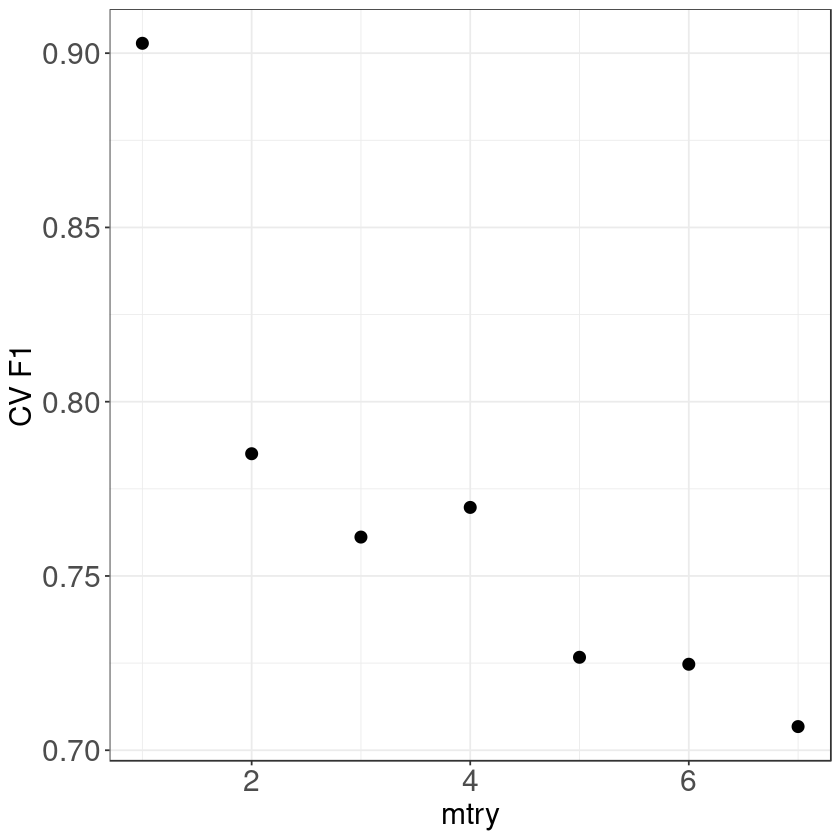

In [14]:
f1 <- function (data, lev = NULL, model = NULL) {
  pred <- data$pred[!is.na(data$pred)&!is.na(data$obs)]
  obs <- data$obs[!is.na(data$pred)&!is.na(data$obs)]
  precision <- posPredValue(pred, obs, positive = lev[2])
  recall  <- sensitivity(pred, obs, postive = lev[1])
  f1_val <- (2 * precision * recall) / (precision + recall)
  names(f1_val) <- c("F1")
  #print(precision)
  #print(recall)
  #print(f1_val)
  f1_val
}

train.rf <- train(label_disappeared ~ X24h + X14d + X45d + Social + Mkt..Cap + Age..mo. + Business,
                  data = train_data,
                  method = "rf",
                  na.action  = na.omit,
                  tuneGrid = data.frame(mtry=1:7),
                  trControl = trainControl(method="cv", number=5, summaryFunction = f1),
                  metric = "F1")
train.rf$results
train.rf
best.rf <- train.rf$finalModel
pred.rf <- predict(best.rf, newdata = test_data.mm) # can use same model matrix

ggplot(train.rf$results, aes(x = mtry, y = F1)) + geom_point(size = 3) + 
  ylab("CV F1") + theme_bw() + theme(axis.title=element_text(size=18), axis.text=element_text(size=18))

An mtry of 3 looks good. We can try sampling stratification to handle the imbalance of the data.

In [15]:
set.seed(42)
rare.class.prevalence = 0.2
nRareSamples = 1000 * rare.class.prevalence
mod.rf <- randomForest(label_disappeared ~ X24h + X14d + X45d + Social + Mkt..Cap + Age..mo. + Business, data = train_data, mtry = 3, nodesize = 5, ntree = 1000,strata=train_data$label_disappeared,
                     sampsize=c(nRareSamples,nRareSamples), na.action = na.omit)
# print(mod.rf)

pred.rf <- predict(mod.rf, newdata = test_data)

table(test_data$label_disappeared, pred.rf)

tableAccuracy(test_data$label_disappeared, pred.rf)
tableTPR(test_data$label_disappeared, pred.rf)
tableFPR(test_data$label_disappeared, pred.rf)

       pred.rf
        FALSE TRUE
  FALSE   427   10
  TRUE     70   19

[1] 0.844697

[1] 0.2134831

[1] 0.0228833

c) Boosting

Finally we can try a boosting method with cross-validation.

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.9097            -nan     0.0010    0.0000
     2        0.9096            -nan     0.0010    0.0000
     3        0.9095            -nan     0.0010    0.0000
     4        0.9094            -nan     0.0010    0.0000
     5        0.9093            -nan     0.0010    0.0000
     6        0.9092            -nan     0.0010    0.0000
     7        0.9091            -nan     0.0010    0.0000
     8        0.9090            -nan     0.0010    0.0000
     9        0.9088            -nan     0.0010    0.0000
    10        0.9087            -nan     0.0010    0.0000
    20        0.9077            -nan     0.0010    0.0000
    40        0.9056            -nan     0.0010    0.0000
    60        0.9037            -nan     0.0010    0.0000
    80        0.9021            -nan     0.0010    0.0000
   100        0.9005            -nan     0.0010    0.0000
   120        0.8988            -nan     0.0010    0.0000
   140        

Stochastic Gradient Boosting 

1233 samples
   7 predictor
   2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 980, 978, 980, 979, 979 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa      
   1                  1000    0.8308854  0.000000000
   1                  2000    0.8308854  0.000000000
   1                  3000    0.8308888  0.006380826
   1                  4000    0.8374295  0.079674636
   1                  5000    0.8398852  0.117616678
   1                  6000    0.8423408  0.143693810
   1                  7000    0.8431538  0.155357604
   1                  8000    0.8423442  0.158346300
   1                  9000    0.8423442  0.168703773
   1                 10000    0.8447998  0.188762717
   2                  1000    0.8308854  0.000000000
   2                  2000    0.8415212  0.116294642
   2                  3000    0.8431538  0.150389427
   2           

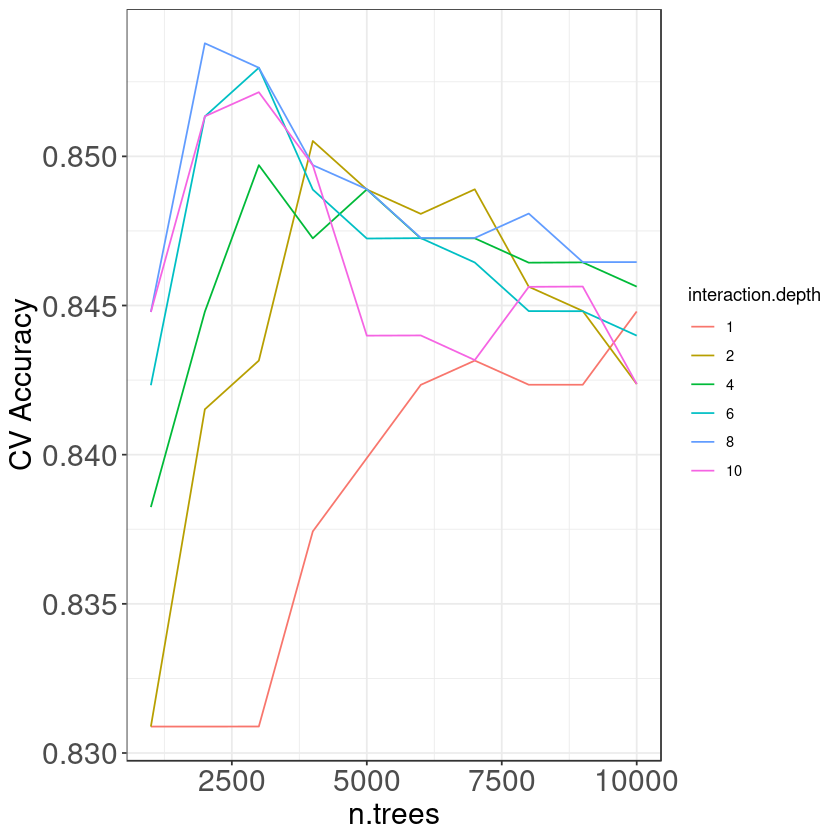

In [17]:
tGrid = expand.grid(n.trees = (1:10)*1000, interaction.depth = c(1,2,4,6,8,10),
                    shrinkage = 0.001, n.minobsinnode = 10)

set.seed(42)
train.boost <- train(label_disappeared ~ X24h + X14d + X45d + Social + Mkt..Cap + Age..mo. + Business,
                     data = train_data,
                     method = "gbm",   ## gradient boosting machine 
                     tuneGrid = tGrid,
                     trControl = trainControl(method="cv", number=5),
                     metric = "Accuracy",
                     na.action = na.omit)
train.boost
best.boost <- train.boost$finalModel

ggplot(train.boost$results, aes(x = n.trees, y = Accuracy, colour = as.factor(interaction.depth))) + geom_line() + 
  ylab("CV Accuracy") + theme_bw() + theme(axis.title=element_text(size=18), axis.text=element_text(size=18)) + 
  scale_color_discrete(name = "interaction.depth")

We choose n.trees = 2000, interaction.depth = 8.

In [18]:
pred.best.boost <- predict(best.boost, newdata = test_data.mm, n.trees = 2000, interaction.depth = 8) # from CV plot

table(test_data$label_disappeared, pred.best.boost>0.7)

tableAccuracy(test_data$label_disappeared, pred.best.boost>0.7)
tableTPR(test_data$label_disappeared, pred.best.boost>0.7)
tableFPR(test_data$label_disappeared, pred.best.boost>0.7)

       
        FALSE TRUE
  FALSE   221  218
  TRUE     70   19

[1] 0.4545455

[1] 0.2134831

[1] 0.4965831

## Portfolio determination based on naive growth rates

a) Regression

We try a linear model on a lot of features.

In [22]:
set.seed(42)
split = sample.split(df$label_growth_rate_Price, SplitRatio = 0.7)
price_train_data <- filter(df, split== TRUE)
price_test_data <- filter(df, split== FALSE)

price_train_data = price_train_data %>% filter(as.integer(label_disappeared)==1)# we keep label_disappeared = FALSE
price_test_data = price_test_data %>% filter(as.integer(label_disappeared)==1)

mod <- lm(label_growth_rate_Price ~ Price + X1h + X24h + X7d + X14d + X30d + X45d + X90d + X200d + 
            Mkt..Cap + X24h.Vol + Circ..Supply + Total.Supply + Team + Product + Coin + Social + Communication + Business + Avg..volume + Age..mo., data = price_train_data)

summary(mod)

pred_lm = predict(mod, newdata = price_test_data)

all_metrics(price_test_data$label_growth_rate_Price, pred_lm, price_train_data$label_growth_rate_Price)


Call:
lm(formula = label_growth_rate_Price ~ Price + X1h + X24h + X7d + 
    X14d + X30d + X45d + X90d + X200d + Mkt..Cap + X24h.Vol + 
    Circ..Supply + Total.Supply + Team + Product + Coin + Social + 
    Communication + Business + Avg..volume + Age..mo., data = price_train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-95.323  -0.448   0.006   0.504 157.521 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.380e+00  1.463e+00  -0.943    0.346    
Price         -1.363e-05  9.791e-04  -0.014    0.989    
X1h            2.563e-02  2.873e-02   0.892    0.373    
X24h          -1.096e-02  9.764e-03  -1.122    0.262    
X7d           -3.442e-03  7.134e-03  -0.482    0.630    
X14d           9.311e-04  3.500e-03   0.266    0.790    
X30d           5.279e-04  4.867e-03   0.108    0.914    
X45d          -2.804e-03  2.983e-03  -0.940    0.347    
X90d           5.591e-03  5.494e-03   1.018    0.309    
X200d         -2.616e-03  5.139e-03 

[1]  582.295130    2.153326 -173.530306

In [23]:
vif(mod)

Price           X1h          X24h           X7d          X14d 
     1.024239      1.276950      2.208573      2.202622     51.039905 
         X30d          X45d          X90d         X200d      Mkt..Cap 
    57.834131     16.350297      6.774587      3.772069      1.026942 
     X24h.Vol  Circ..Supply  Total.Supply          Team       Product 
     1.028760      1.076608      1.010722      6.496378      1.971038 
         Coin        Social Communication      Business   Avg..volume 
     1.905901      3.143330      1.534082      1.361852      1.021657 
     Age..mo. 
     1.302845

This is not good, there is some multicolinearity. Let's remove the guilty features.

In [26]:
mod <- lm(label_growth_rate_Price ~ Price + X1h + X24h + X7d + X30d + X90d + X200d + 
            Mkt..Cap + X24h.Vol + Circ..Supply + Total.Supply + Team + Product + Coin + Social + Communication + Business + Avg..volume + Age..mo., data = price_train_data)

summary(mod)

pred_lm = predict(mod, newdata = price_test_data)

all_metrics(price_test_data$label_growth_rate_Price, pred_lm, price_train_data$label_growth_rate_Price)


Call:
lm(formula = label_growth_rate_Price ~ Price + X1h + X24h + X7d + 
    X30d + X90d + X200d + Mkt..Cap + X24h.Vol + Circ..Supply + 
    Total.Supply + Team + Product + Coin + Social + Communication + 
    Business + Avg..volume + Age..mo., data = price_train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-95.222  -0.426  -0.009   0.496 157.685 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.506e+00  1.452e+00  -1.037   0.2999    
Price         -1.311e-05  9.783e-04  -0.013   0.9893    
X1h            2.299e-02  2.857e-02   0.805   0.4212    
X24h          -9.303e-03  9.536e-03  -0.976   0.3295    
X7d           -3.687e-03  7.124e-03  -0.517   0.6049    
X30d          -8.050e-05  9.549e-04  -0.084   0.9328    
X90d           1.554e-03  3.466e-03   0.448   0.6541    
X200d         -4.926e-04  4.608e-03  -0.107   0.9149    
Mkt..Cap       5.801e-05  1.061e-03   0.055   0.9564    
X24h.Vol       7.150e-05  1.114e-03   0.064   0.94

[1]  564.062943    1.900256 -168.065604

In [27]:
vif(mod)

Price           X1h          X24h           X7d          X30d 
     1.023835      1.263786      2.109159      2.199134      2.228729 
         X90d         X200d      Mkt..Cap      X24h.Vol  Circ..Supply 
     2.699683      3.036480      1.026658      1.025089      1.076110 
 Total.Supply          Team       Product          Coin        Social 
     1.009432      6.461087      1.967923      1.888820      3.118537 
Communication      Business   Avg..volume      Age..mo. 
     1.533213      1.360887      1.021589      1.272101

This still does not look good. Let's narrow down the features.

In [20]:
mod <- lm(label_growth_rate_Price ~ Circ..Supply + Total.Supply + 0, data = price_train_data)

summary(mod)

pred_lm = predict(mod, newdata = price_test_data)

all_metrics(price_test_data$label_growth_rate_Price, pred_lm, price_train_data$label_growth_rate_Price)


Call:
lm(formula = label_growth_rate_Price ~ Circ..Supply + Total.Supply + 
    0, data = price_train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-96.415  -0.701  -0.407   0.164 158.564 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
Circ..Supply -2.534e-03  8.533e-04   -2.97  0.00305 ** 
Total.Supply  9.579e-12  3.097e-13   30.93  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.074 on 1017 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.485,	Adjusted R-squared:  0.484 
F-statistic: 478.9 on 2 and 1017 DF,  p-value: < 2.2e-16


[1]  547.596912    1.941018 -166.769645

We can compare it to the baseline (predicting negative all the time). We assume that we invest the same amount of money in each coin, ignoring fees, and compute the result growth rate of our portfolio following our regression strategy and the baseline.

In [29]:
filter_vec = !is.na(pred_lm)
sum((pred_lm*price_test_data$label_growth_rate_Price)[filter_vec])/sum(pred_lm[filter_vec])

# Baseline
sum(price_test_data$label_growth_rate_Price[filter_vec])/length(price_test_data$label_growth_rate_Price[filter_vec])

[1] 0.1421309

[1] -0.3421253

We beat it!

### Portfolio determination in a log normal stock model

a) Regression

With our new log-normal assumption we can try to predict the difference of the logarithms of the price between March and December.

In [30]:
df$price_log_diff = log(df$label_Price) - log(df$Price) # follow mu T + sigma B_T

split = sample.split(df$price_log_diff, SplitRatio = 0.7)
price_train_data <- filter(df, split== TRUE)
price_test_data <- filter(df, split== FALSE)

price_train_data = price_train_data %>% filter(as.integer(label_disappeared)==1) # we keep label_disappeared = FALSE
price_test_data = price_test_data %>% filter(as.integer(label_disappeared)==1)

mod_log <- lm(price_log_diff ~ Price + X1h + X24h + X7d + X14d + X30d + X45d + X90d + X200d + 
            Mkt..Cap + X24h.Vol + Circ..Supply + Total.Supply + Team + Product + Coin + Social + Communication + Business + Avg..volume + Age..mo., data = price_train_data)

summary(mod_log)

pred_lm = predict(mod_log, newdata = price_test_data)

all_metrics(price_test_data$price_log_diff, pred_lm, price_train_data$price_log_diff)


Call:
lm(formula = price_log_diff ~ Price + X1h + X24h + X7d + X14d + 
    X30d + X45d + X90d + X200d + Mkt..Cap + X24h.Vol + Circ..Supply + 
    Total.Supply + Team + Product + Coin + Social + Communication + 
    Business + Avg..volume + Age..mo., data = price_train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2257 -0.4446  0.0628  0.5709  3.8110 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -9.089e-01  1.915e-01  -4.747 2.37e-06 ***
Price          2.427e-05  3.484e-05   0.697   0.4861    
X1h           -3.607e-03  5.843e-03  -0.617   0.5372    
X24h          -3.514e-03  1.624e-03  -2.164   0.0307 *  
X7d           -1.298e-03  1.028e-03  -1.262   0.2074    
X14d          -6.971e-04  3.174e-04  -2.196   0.0283 *  
X30d           5.989e-04  4.839e-04   1.238   0.2161    
X45d           6.502e-05  2.585e-04   0.252   0.8014    
X90d           5.886e-04  5.132e-04   1.147   0.2517    
X200d         -9.859e-04  5.229e-04  -1.885  

[1]  1.37419565  0.78660032 -0.05102702

In [31]:
vif(mod_log)

Price           X1h          X24h           X7d          X14d 
     1.064074      1.071160      1.225442      1.313303    753.264206 
         X30d          X45d          X90d         X200d      Mkt..Cap 
  1730.326012    491.069203     10.681541      3.598444      1.024747 
     X24h.Vol  Circ..Supply  Total.Supply          Team       Product 
     1.025179      1.078712      1.018917      6.371922      1.925379 
         Coin        Social Communication      Business   Avg..volume 
     1.866821      3.145436      1.525067      1.355906      1.092920 
     Age..mo. 
     1.312306

In [34]:
mod_log <- lm(price_log_diff ~ Price + X1h + X24h + X7d + X14d + X90d + X200d + 
            Mkt..Cap + X24h.Vol + Circ..Supply + Total.Supply + Team + Product + Coin + Social + Communication + Business + Avg..volume + Age..mo., data = price_train_data)

summary(mod_log)

pred_lm = predict(mod_log, newdata = price_test_data)

all_metrics(price_test_data$price_log_diff, pred_lm, price_train_data$price_log_diff)


Call:
lm(formula = price_log_diff ~ Price + X1h + X24h + X7d + X14d + 
    X90d + X200d + Mkt..Cap + X24h.Vol + Circ..Supply + Total.Supply + 
    Team + Product + Coin + Social + Communication + Business + 
    Avg..volume + Age..mo., data = price_train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1966 -0.4454  0.0553  0.5753  3.7657 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -9.555e-01  1.909e-01  -5.005 6.62e-07 ***
Price          2.525e-05  3.491e-05   0.723 0.469718    
X1h           -3.627e-03  5.851e-03  -0.620 0.535459    
X24h          -3.597e-03  1.626e-03  -2.212 0.027225 *  
X7d           -1.328e-03  1.029e-03  -1.291 0.196887    
X14d          -4.881e-05  2.479e-05  -1.969 0.049266 *  
X90d           8.115e-04  4.038e-04   2.010 0.044752 *  
X200d         -1.469e-03  4.261e-04  -3.448 0.000589 ***
Mkt..Cap      -2.973e-04  1.391e-04  -2.138 0.032777 *  
X24h.Vol      -6.626e-06  1.412e-04  -0.047 0.962579    
Ci

[1]  1.37718128  0.78945158 -0.05331052

In [35]:
vif(mod_log)

Price           X1h          X24h           X7d          X14d 
     1.063894      1.069542      1.223252      1.308153      4.575764 
         X90d         X200d      Mkt..Cap      X24h.Vol  Circ..Supply 
     6.584021      2.379537      1.024372      1.024142      1.078095 
 Total.Supply          Team       Product          Coin        Social 
     1.014160      6.347607      1.920366      1.862688      3.133121 
Communication      Business   Avg..volume      Age..mo. 
     1.522168      1.355051      1.092626      1.297297

The VIF is okay now.Let's remove some features.

In [38]:
mod_log <- lm(price_log_diff ~ X24h + X200d + Mkt..Cap + Business, data = price_train_data)

summary(mod_log)

pred_lm_log = predict(mod_log, newdata = price_test_data)

all_metrics(price_test_data$price_log_diff, pred_lm_log, price_train_data$price_log_diff)


Call:
lm(formula = price_log_diff ~ X24h + X200d + Mkt..Cap + Business, 
    data = price_train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2460 -0.4330  0.0580  0.5923  3.9618 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.7949174  0.1167271  -6.810 1.68e-11 ***
X24h        -0.0047998  0.0014715  -3.262  0.00114 ** 
X200d       -0.0008992  0.0002755  -3.265  0.00113 ** 
Mkt..Cap    -0.0003394  0.0001378  -2.464  0.01392 *  
Business    -0.0027869  0.0012598  -2.212  0.02717 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9794 on 1000 degrees of freedom
  (32 observations deleted due to missingness)
Multiple R-squared:  0.03057,	Adjusted R-squared:  0.02669 
F-statistic: 7.883 on 4 and 1000 DF,  p-value: 2.956e-06


[1]  1.35643668  0.78498288 -0.04019291

In [39]:
filter_vec = !is.na(pred_lm_log)
sum((exp(pred_lm_log)*price_test_data$label_growth_rate_Price)[filter_vec])/sum(exp(pred_lm_log)[filter_vec])

# Baseline
sum(price_test_data$label_growth_rate_Price[filter_vec])/length(price_test_data$label_growth_rate_Price[filter_vec])

[1] 0.4614368

[1] 0.4393909

That's fine but not amazing, let's think a bit and try something else.

In [40]:
mod_log <- lm(price_log_diff ~ X7d + Mkt..Cap + Age..mo., data = price_train_data)

summary(mod_log)

pred_lm_log = predict(mod_log, newdata = price_test_data)

all_metrics(price_test_data$price_log_diff, pred_lm_log, price_train_data$price_log_diff)


Call:
lm(formula = price_log_diff ~ X7d + Mkt..Cap + Age..mo., data = price_train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3005 -0.4493  0.0632  0.5849  3.9844 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.0571347  0.0505030 -20.932   <2e-16 ***
X7d         -0.0016871  0.0009027  -1.869   0.0619 .  
Mkt..Cap    -0.0003295  0.0001397  -2.359   0.0185 *  
Age..mo.     0.0041164  0.0019420   2.120   0.0343 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9966 on 1033 degrees of freedom
Multiple R-squared:  0.01299,	Adjusted R-squared:  0.01012 
F-statistic: 4.531 on 3 and 1033 DF,  p-value: 0.003655


[1] 1.33219063 0.76620542 0.01527807

In [41]:
filter_vec = !is.na(pred_lm_log)
sum((exp(pred_lm_log)*price_test_data$label_growth_rate_Price)[filter_vec])/sum(exp(pred_lm_log)[filter_vec])

# Baseline
sum(price_test_data$label_growth_rate_Price[filter_vec])/length(price_test_data$label_growth_rate_Price[filter_vec])

[1] 0.5003607

[1] 0.4127445

Much better already!
We see that filtering out coisn where informations are missing, our portfolio behaves already better! That's because trustworthy coins get all their information filled.

b) Random forest

We take the features from the 2 previous models and we try it out on a random forest.

In [50]:
price_test_data_filled_with_0 <- price_test_data
price_test_data_filled_with_0[is.na(price_test_data_filled_with_0)] <- 0
price_test_data_log.mm = as.data.frame(model.matrix(price_log_diff ~ X24h + X7d + X200d + Mkt..Cap + Age..mo. + Business, data = price_test_data_filled_with_0))

train.rf <- train(price_log_diff ~ X24h + X7d + X200d + Mkt..Cap + Age..mo. + Business,
                  data = price_train_data,
                  method = "rf",
                  na.action  = na.omit,
                  tuneGrid = data.frame(mtry=1:6),
                  trControl = trainControl(method="cv", number=5),
                  distribution="gaussian",
                  metric = "RMSE")
train.rf$results
train.rf
best.rf <- train.rf$finalModel
pred.rf <- predict(best.rf, newdata = price_test_data_log.mm)
all_metrics(price_test_data$price_log_diff, pred_lm_log, price_train_data$price_log_diff)

mtry,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9868626,0.02396270,0.7021205,0.09754761,0.03461219,0.04148504
2,1.0030523,0.02013034,0.7180743,0.09988699,0.03206543,0.03882143
3,1.0138758,0.01549198,0.7273112,0.10018572,0.02833747,0.03858953
4,1.0172491,0.01483976,0.7298685,0.09965039,0.02697329,0.04055537
5,1.0190250,0.01714539,0.7307562,0.10116483,0.03156220,0.03939837
6,1.0224764,0.01754349,0.7330653,0.10168716,0.03172612,0.04190727


Random Forest 

1037 samples
   6 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 804, 805, 805, 804, 802 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared    MAE      
  1     0.9868626  0.02396270  0.7021205
  2     1.0030523  0.02013034  0.7180743
  3     1.0138758  0.01549198  0.7273112
  4     1.0172491  0.01483976  0.7298685
  5     1.0190250  0.01714539  0.7307562
  6     1.0224764  0.01754349  0.7330653

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 1.

[1] 1.33219063 0.76620542 0.01527807

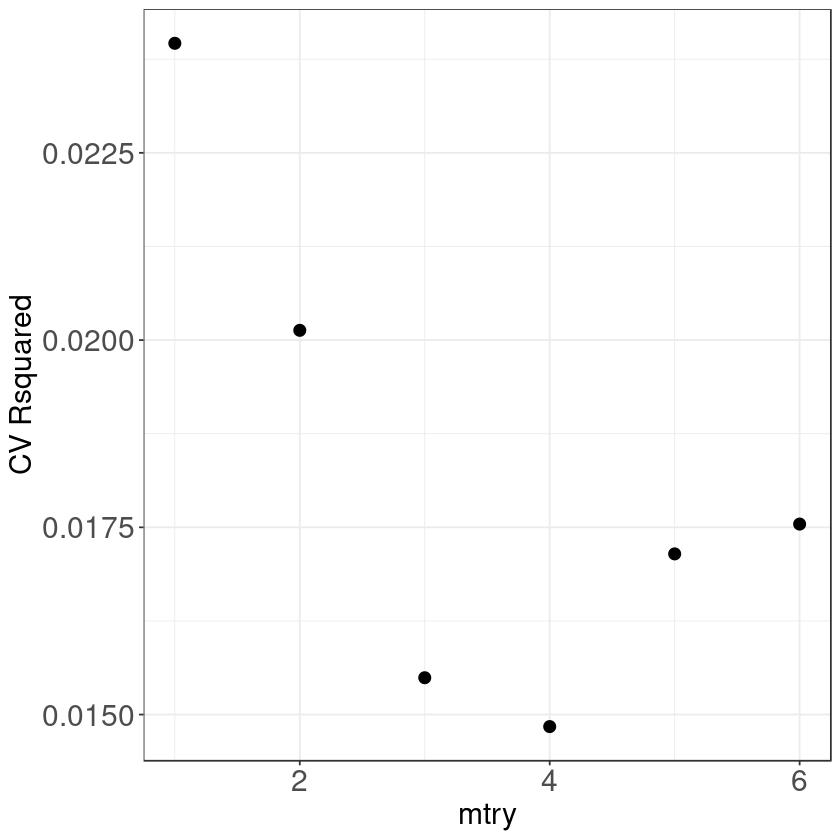

In [51]:
ggplot(train.rf$results, aes(x = mtry, y = Rsquared)) + geom_point(size = 3) + 
  ylab("CV Rsquared") + theme_bw() + theme(axis.title=element_text(size=18), axis.text=element_text(size=18))

The best value is 1for mtry.

In [52]:
filter_vec = !is.na(pred.rf)
sum((exp(pred.rf)*price_test_data$label_growth_rate_Price)[filter_vec])/sum(exp(pred.rf)[filter_vec])

# Baseline
sum(price_test_data$label_growth_rate_Price[filter_vec])/length(price_test_data$label_growth_rate_Price[filter_vec])

[1] 0.3181264

[1] 0.4109499

Unfortunately this model does not beat the baseline.

c) Boosting

We use the same features.

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.9141            -nan     0.0010    0.0000
     2        0.9141            -nan     0.0010    0.0000
     3        0.9140            -nan     0.0010    0.0000
     4        0.9140            -nan     0.0010   -0.0000
     5        0.9139            -nan     0.0010    0.0000
     6        0.9139            -nan     0.0010    0.0000
     7        0.9139            -nan     0.0010   -0.0000
     8        0.9139            -nan     0.0010   -0.0000
     9        0.9138            -nan     0.0010    0.0000
    10        0.9138            -nan     0.0010    0.0000
    20        0.9135            -nan     0.0010    0.0000
    40        0.9129            -nan     0.0010    0.0000
    60        0.9123            -nan     0.0010    0.0000
    80        0.9118            -nan     0.0010   -0.0000
   100        0.9112            -nan     0.0010    0.0000
   120        0.9107            -nan     0.0010    0.0000
   140        

Stochastic Gradient Boosting 

1037 samples
   6 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 803, 804, 805, 804, 804 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared     MAE      
   1                  1000    0.9858976  0.010603419  0.7076001
   1                  2000    0.9851314  0.011104414  0.7062743
   1                  3000    0.9856436  0.011144693  0.7059326
   1                  4000    0.9863903  0.011117194  0.7059703
   1                  5000    0.9871802  0.011010157  0.7063646
   1                  6000    0.9878797  0.011004908  0.7066601
   1                  7000    0.9887009  0.011055891  0.7070122
   1                  8000    0.9896128  0.010921603  0.7075789
   1                  9000    0.9901955  0.010995671  0.7080814
   1                 10000    0.9907626  0.011038617  0.7085055
   2                  1000    0.9849925  0.012421137  0.7060668
   2                

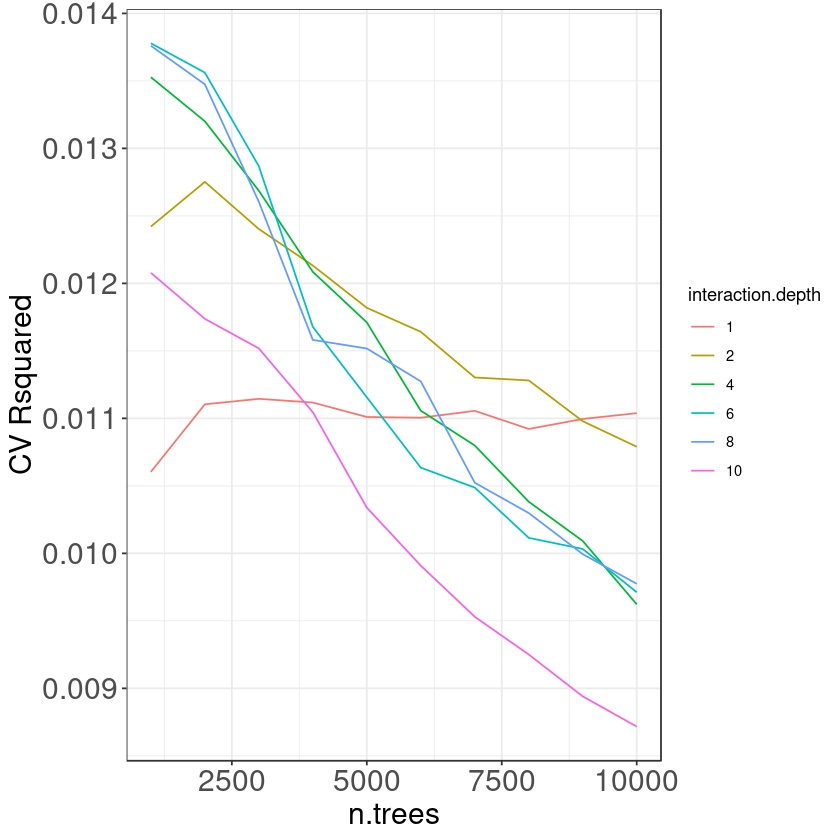

In [54]:
tGrid = expand.grid(n.trees = (1:10)*1000, interaction.depth = c(1,2,4,6,8,10),
                    shrinkage = 0.001, n.minobsinnode = 10)

set.seed(42)
train.boost <- train(price_log_diff ~ X24h + X7d + X200d + Mkt..Cap + Age..mo. + Business,
                     data = price_train_data,
                     method = "gbm",   ## gradient boosting machine 
                     tuneGrid = tGrid,
                     trControl = trainControl(method="cv", number=5),
                     distribution = "gaussian",
                     metric = "RMSE",
                     na.action = na.omit)
train.boost
best.boost <- train.boost$finalModel

ggplot(train.boost$results, aes(x = n.trees, y = Rsquared, colour = as.factor(interaction.depth))) + geom_line() + 
  ylab("CV Rsquared") + theme_bw() + theme(axis.title=element_text(size=18), axis.text=element_text(size=18)) + 
  scale_color_discrete(name = "interaction.depth")

The best parameters are the biggest ones.

In [56]:
pred.best.boost <- predict(best.boost, newdata = price_test_data_log.mm, n.trees = 10000, interaction.depth=10) # from CV plot

Warning message in predict.gbm(best.boost, newdata = price_test_data_log.mm, n.trees = 10000, :
“Number of trees not specified or exceeded number fit so far. Using 1000.”

It does  not want to do it so we need to do it ourselves.

In [63]:
library(gbm)

mod.boost <- gbm(price_log_diff ~ X24h + X7d + X200d + Mkt..Cap + Age..mo. + Business,
                     data = price_train_data,
                     distribution = "gaussian",
                     n.trees = 10000,
                     shrinkage = 0.001,
                     interaction.depth = 10)

# NOTE: we need to specify number of trees to get a prediction for boosting
pred.boost <- predict(mod.boost, newdata = price_test_data_log.mm, n.trees=10000)

In [64]:
filter_vec = !is.na(pred.boost)
sum((exp(pred.boost)*price_test_data$label_growth_rate_Price)[filter_vec])/sum(exp(pred.boost)[filter_vec])

# Baseline
sum(price_test_data$label_growth_rate_Price[filter_vec])/length(price_test_data$label_growth_rate_Price[filter_vec])

[1] 0.2901236

[1] 0.4109499

This is also very bad compared to the baseline. Too much overfitting!